In [34]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import regularizers

In [35]:
from tensorflow.keras.layers import *
from keras.preprocessing import image
from tensorflow.keras import metrics
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from skimage.transform import resize
from tqdm import tqdm
import cv2
import random


In [36]:
def load_model_segm(val_tf_dataset, val_batch_size, val_steps_per_epoch):
    model_segm = load_model("models/segm")
    # Evaluate the restored model
    results = model_segm.evaluate(val_tf_dataset, batch_size=val_batch_size, steps=val_steps_per_epoch, verbose=2)
    print("Results of evaluation:", results)
    return model_segm

In [37]:
def fit_and_save_model_segm(model_segm, train_dataset, val_dataset, epochs, train_steps_per_epoch, val_steps_per_epoch, saveto, callbacks = None):
    result_segm = model_segm.fit(
        train_dataset, 
        steps_per_epoch=train_steps_per_epoch, 
        epochs=epochs,
        validation_data=val_dataset,
        validation_steps=val_steps_per_epoch, 
        initial_epoch=0, 
        callbacks=callbacks
    )
    model_segm.save(saveto)
    print("model saved: ", saveto)
    return model_segm

In [38]:
# Define dice loss
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    # Dice = (2*|X & Y|)/ (|X|+ |Y|) =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))   ref: https://arxiv.org/pdf/1606.04797v1.pdf
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [39]:
# img size should be between 75 and image size
def get_train_test_data(split_percent=0.2, img_size=75):
    print("X_train, X_valid, y_train, y_valid generating...")

    #loading the dataframe containing images after removing conflicting images
    df=pd.read_csv('../train_masks.csv')
    img=pd.read_csv('../dup_rem.csv')
    img.drop('Unnamed: 0',axis=1,inplace=True)
    img.image_name=img.image_name.astype(int)
    img.subject_name=img.subject_name.astype(int)
    img.columns=['image_path','img','subject','mask_path']
    new_df=pd.merge(img,df,on=['img','subject'])
    new_df.pixels.fillna(0,inplace=True)
    val=[0 if i==0 else 1 for i in new_df.pixels]
    new_df['mask_pres']=val
    pos_df=new_df[new_df.mask_pres==1]

    #Get array of all images based on their path (resized and normalized)
    X = []
    for path in tqdm(pos_df.image_path):
        img1=cv2.imread("../raw/"+str(path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img1=resize(np.reshape(img1, (np.shape(img1)[0], np.shape(img1)[1],1)), (img_size, img_size))
        X.append(img1)
        
    #Get array of all masks based on their path (resized and normalized)
    Y = []
    for path in tqdm(pos_df.mask_path):
        img1=cv2.imread("../raw/"+str(path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img1 = cv2.resize(img1,(img_size,img_size),interpolation=cv2.INTER_NEAREST)
        img1=np.reshape(img1, (img_size, img_size,1))
        Y.append(img1)
        

    return train_test_split(X, Y, test_size=split_percent, random_state=42)

In [40]:
# pos_df.head(10)

In [41]:
'''Construct a data generator using tf.Dataset'''
def convert_to_tf_dataset(images, labels, batch_size=64):
    # TODO: apply some augmentation (rotation, flipping)

    def normalize(input_image):
        input_image = tf.cast(input_image, tf.float32) / 255.0
        return input_image

    def load_image(datapoint):
        input_image = normalize(datapoint['image'])
        input_mask = normalize(datapoint['mask'])
        return input_image, input_mask

    dataset = tf.data.Dataset.from_tensor_slices({'image': images, 'mask': labels})
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    batches = (dataset.cache().shuffle(100).batch(batch_size).repeat().prefetch(buffer_size=tf.data.AUTOTUNE))

    return batches

In [42]:
IMG_SIZE = 128
EPOCHS = 20
BATCH_SIZE_TRAIN = 40
BATCH_SIZE_TEST = 40

In [43]:
tf.keras.backend.clear_session()
tf.keras.backend.set_image_data_format('channels_last')

In [11]:
X_train, X_valid, y_train, y_valid = get_train_test_data(0.2, IMG_SIZE)

X_train, X_valid, y_train, y_valid generating...


100%|██████████| 2323/2323 [00:02<00:00, 977.74it/s] 


In [12]:
TRAIN_STEPS_PER_EPOCH = len(y_train) // BATCH_SIZE_TRAIN
VAL_STEPS_PER_EPOCH = len(y_valid) // BATCH_SIZE_TEST

In [13]:
print(X_train[0].shape)
print(y_train[0].shape)
print(len(X_train))
print(len(X_valid))

(128, 128, 1)
(128, 128, 1)
1858
465


In [17]:
train_tf_dataset = convert_to_tf_dataset(X_train, y_train, BATCH_SIZE_TRAIN)
valid_tf_dataset = convert_to_tf_dataset(X_valid, y_valid, BATCH_SIZE_TEST)

In [16]:
train_tf_dataset.take(0)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

In [17]:
train_tf_dataset.take(1857)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

In [18]:
def atrous_block(input):
  '''Implement DAC block as given in paper'''
  q1=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr0',dilation_rate=1,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr1',dilation_rate=2,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr2',dilation_rate=1,activation='relu')(q2)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr3',dilation_rate=1,activation='relu')(input)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr4',dilation_rate=2,activation='relu')(q3)
  q3=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr5',dilation_rate=1,activation='relu')(q3)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr6',dilation_rate=1,activation='relu')(input)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr7',dilation_rate=2,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr8',dilation_rate=4,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr9',dilation_rate=1,activation='relu')(q4)
  atr_out=concatenate([q1,q2,q3,q4],axis=-1)
  print(atr_out.shape)
  return atr_out


In [19]:
def rmp_block(input):
  '''Implement RMP block as given in paper'''
  X1=MaxPooling2D((2,2),strides=(2,2))(input)
  X1=Conv2DTranspose(512,(2,2),padding='same',activation='relu',strides=(2,2))(X1)
  X2=MaxPooling2D((3,3),strides=(2,2),padding='same')(input)
  X2=Conv2DTranspose(512,(3,3),padding='same',activation='relu',strides=(2,2))(X2)
  X3=MaxPooling2D((5,5),strides=(2,2),padding='same')(input)
  X3=Conv2DTranspose(512,(5,5),padding='same',activation='relu',strides=(2,2))(X3)
  X4=MaxPooling2D((6,6),strides=(2,2),padding='same')(input)
  X4=Conv2DTranspose(512,(6,6),padding='same',activation='relu',strides=(2,2))(X4)
  concat=concatenate([X1,X2,X3,X4],axis=-1)
  return concat


In [20]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    #conv layer followed by batchnormalization
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=regularizers.l2(1e-4))(input)
    x = Activation('relu')(x)
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=regularizers.l2(1e-4))(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

In [21]:
def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual Unet + Dense Atrous convolution + Rmp block"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)


    conv5 = convolutional_block(drop3, filters = filters * 8, kernel_size = 3, batchnorm = batchnorm)
    #atrous conv or dillated conv is when filter has holes in it.
    conv5=atrous_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 8, kernel_size = 3, batchnorm = batchnorm)
    conv5=rmp_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    ups7 = Conv2DTranspose(filters * 4, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(conv5)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv2DTranspose(filters * 2, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    ups9 = Conv2DTranspose(filters * 1, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Use the same UNET as in license plates task first, see if it works:

In [45]:
import numpy as np
import tensorflow as tf
import cv2
from keras.layers import Conv2D, Dropout, Conv2DTranspose, concatenate, Input, Rescaling, MaxPooling2D
from keras import Model


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_regularizer=regularizers.l2(1e-4),
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())

    return result


# we use fixed size of 128*128*3, output_channels = 3 with pretrained encoder
def build_unet_model_enc_pr():
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',  # 64x64
        'block_3_expand_relu',  # 32x32
        'block_6_expand_relu',  # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',  # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),  # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4), activation = "softmax")  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Use the default plain Unet as in kaggle tutorials

In [22]:
import numpy as np
import tensorflow as tf
import cv2
from keras import layers
from keras.layers import Conv2D, Dropout, Conv2DTranspose, concatenate, Input, Rescaling, MaxPooling2D
from keras import Model

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
   x = BatchNormalization()(x)
   x = Activation('relu')(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = BatchNormalization()(x)
   x = Activation('relu')(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x


def build_unet_model(img_size):
     # inputs
   inputs = layers.Input(shape=(img_size,img_size, 1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 5 - bottleneck
   bottleneck = double_conv_block(p3, 512)
   # decoder: expanding path - upsample
   # 7 - upsample
   u7 = upsample_block(bottleneck, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        label = "Sample Prediction after epoch " + str(epoch)
        show_predictions(model = self.model, label=label)

In [26]:
def display(display_list, label=""):
    if label != "":
        plt.figure(label)
    else:
        plt.figure()
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if (i >= 1):
            plt.imshow(tf.keras.utils.array_to_img(display_list[0]), cmap = 'gray', interpolation = 'none')
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap = 'gray', interpolation = 'none', alpha = 0.5)
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap = 'gray')
        plt.axis('off')
    # plt.show(block=False)
    

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(model, label="", dataset=None, num=1):
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], label)

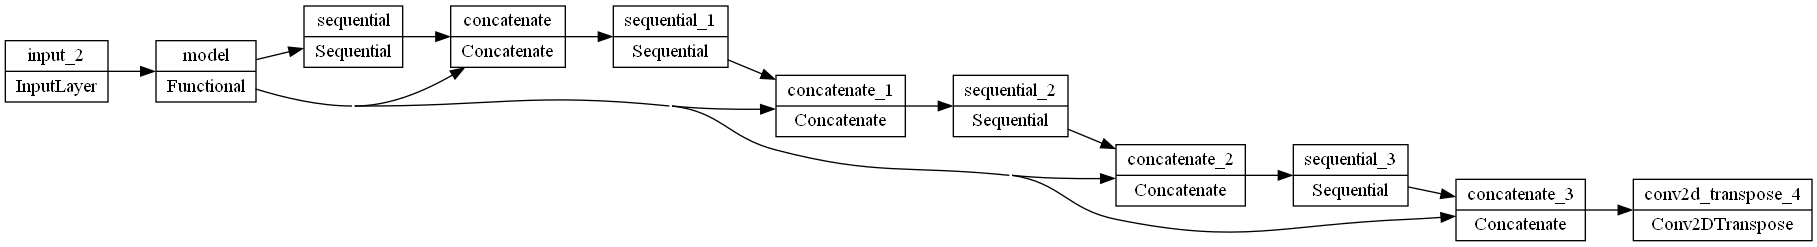

In [49]:
plot_model(model_unet_pr_enc, to_file='model_segmentator_unet_with_pretrained_encoder.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96)

Sample image:


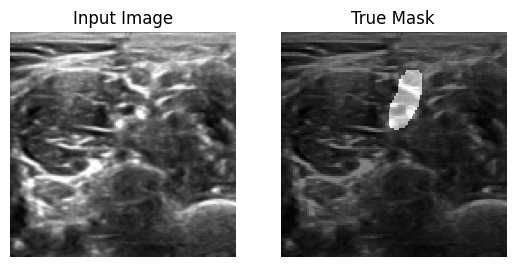

In [27]:
sample_image = 0
sample_mask = 0
for imgs, msks in train_tf_dataset.take(2):
    sample_image, sample_mask = imgs[1], msks[1]
print("Sample image:")
display([sample_image, sample_mask])

In [32]:
model_unet = build_unet_model(IMG_SIZE)
model_unet.summary()
model_unet.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[metrics.MeanIoU(num_classes=3)])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                             

In [28]:
model_resunet = resunet_opt(Input((IMG_SIZE, IMG_SIZE, 1), name='img'), filters=16, dropout=0.4, batchnorm=True)
model_resunet.summary()
model_resunet.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[metrics.MeanIoU(num_classes=3)])

(None, 8, 8, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                          

In [46]:
model_unet_pr_enc = build_unet_model_enc_pr()
model_unet_pr_enc.summary()
model_unet_pr_enc.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[metrics.MeanIoU(num_classes=3)])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [29]:
models = [
    ["model_unet_enc_pr", model_unet_pr_enc, "models/segm_pr_enc_unet"],
    ["model_unet_modified", model_resunet, "models/segm_modified_unet"],
    ["model_unet", model_unet, "models/segm_simple_unet"]
    ]

NameError: name 'model_unet_pr_enc' is not defined

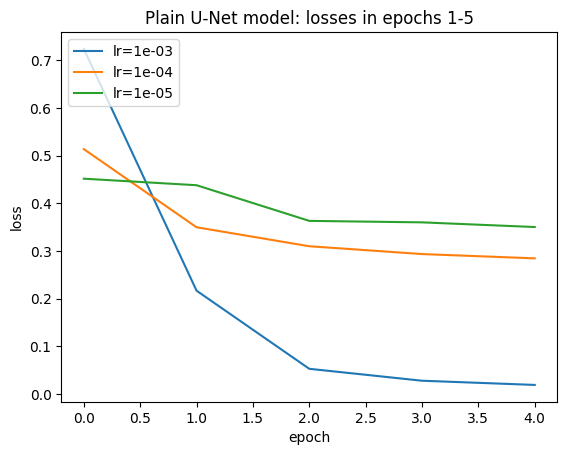

In [8]:
import matplotlib.pyplot as plt

losses_03 = [0.7240, 0.2169,  0.0530, 0.0280, 0.0192]
losses_04 = [0.5138, 0.3499, 0.3101, 0.2937, 0.2847]
losses_05 = [0.4518, 0.4381, 0.3633, 0.3602, 0.3504]

plt.plot(losses_03)
plt.plot(losses_04)
plt.plot(losses_05)
plt.title('Plain U-Net model: losses in epochs 1-5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['lr=1e-03', 'lr=1e-04', 'lr=1e-05'], loc='upper left')
plt.show()

Start training:  model_unet
Epoch 1/5
46/46 [==============================] - 1061s 23s/step - loss: 0.0789 - mean_io_u: 0.4854 - val_loss: 0.0993 - val_mean_io_u: 0.4854
Epoch 2/5
46/46 [==============================] - 1009s 22s/step - loss: 0.0299 - mean_io_u: 0.4854 - val_loss: 0.0675 - val_mean_io_u: 0.4854
Epoch 3/5
46/46 [==============================] - 974s 21s/step - loss: 0.0171 - mean_io_u: 0.4877 - val_loss: 0.0434 - val_mean_io_u: 0.4855
Epoch 4/5
46/46 [==============================] - 937s 20s/step - loss: 0.0121 - mean_io_u: 0.4955 - val_loss: 0.0285 - val_mean_io_u: 0.4854
Epoch 5/5
46/46 [==============================] - 972s 21s/step - loss: 0.0105 - mean_io_u: 0.5001 - val_loss: 0.0214 - val_mean_io_u: 0.4855


INFO:tensorflow:Assets written to: models/segm_simple_unet\assets


INFO:tensorflow:Assets written to: models/segm_simple_unet\assets


model saved:  models/segm_simple_unet


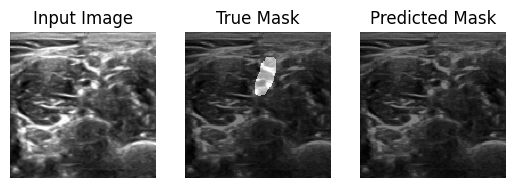

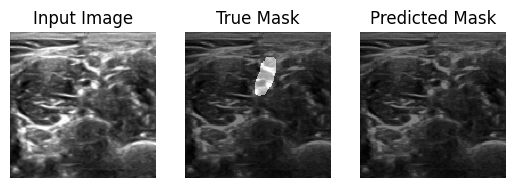

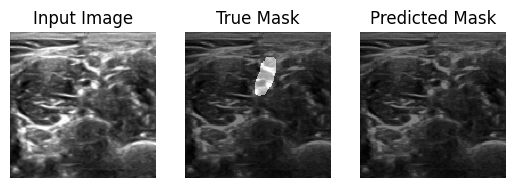

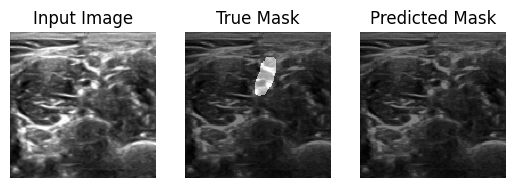

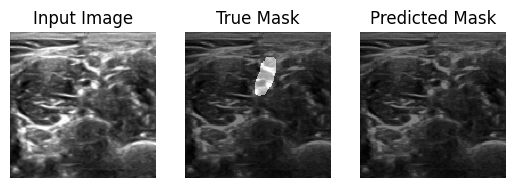

In [30]:
name, model, saveto = ("model_unet", model_unet, "models/segm_simple_unet")
print("Start training: ", name)
fit_and_save_model_segm(
        model, 
        train_tf_dataset, 
        valid_tf_dataset, 
        epochs=5, 
        callbacks=[DisplayCallback()],
        train_steps_per_epoch=TRAIN_STEPS_PER_EPOCH, 
        val_steps_per_epoch=VAL_STEPS_PER_EPOCH, 
        saveto=saveto
        )

Start training:  model_unet
Epoch 1/5
46/46 [==============================] - 1263s 27s/step - loss: 0.1555 - mean_io_u: 0.4918 - val_loss: 0.7240 - val_mean_io_u: 0.1053
Epoch 2/5
46/46 [==============================] - 1228s 27s/step - loss: 0.0445 - mean_io_u: 0.4931 - val_loss: 0.2169 - val_mean_io_u: 0.4887
Epoch 3/5
46/46 [==============================] - 1265s 27s/step - loss: 0.0279 - mean_io_u: 0.4906 - val_loss: 0.0530 - val_mean_io_u: 0.4854
Epoch 4/5
46/46 [==============================] - 1304s 28s/step - loss: 0.0233 - mean_io_u: 0.4920 - val_loss: 0.0280 - val_mean_io_u: 0.4854
Epoch 5/5
46/46 [==============================] - 1228s 27s/step - loss: 0.0209 - mean_io_u: 0.4923 - val_loss: 0.0242 - val_mean_io_u: 0.4854


INFO:tensorflow:Assets written to: models/segm_simple_unet\assets


INFO:tensorflow:Assets written to: models/segm_simple_unet\assets


model saved:  models/segm_simple_unet


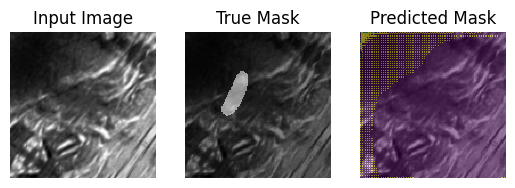

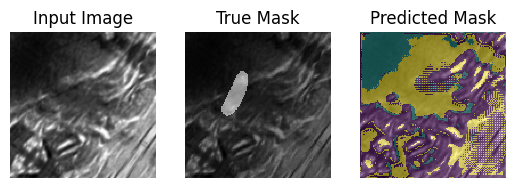

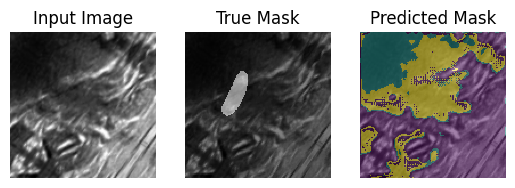

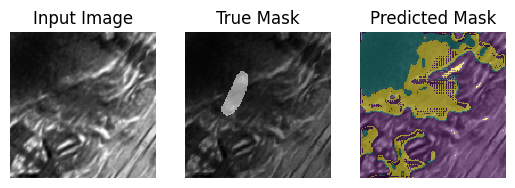

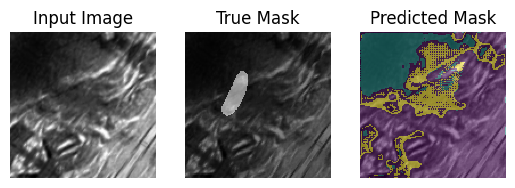

In [31]:
# results for plain U-Net, 5 epochs, adam 1e-03 - terrible overfitting
# name, model, saveto = models[2]
# print("Start training: ", name)
# fit_and_save_model_segm(
#         model, 
#         train_tf_dataset, 
#         valid_tf_dataset, 
#         epochs=5, 
#         callbacks=[DisplayCallback()],
#         train_steps_per_epoch=TRAIN_STEPS_PER_EPOCH, 
#         val_steps_per_epoch=VAL_STEPS_PER_EPOCH, 
#         saveto=saveto
#         )

Start training:  model_unet_enc_pr
Epoch 1/20
30/30 [==============================] - 171s 5s/step - loss: 0.3558 - mean_io_u_8: 0.4853 - val_loss: 0.2838 - val_mean_io_u_8: 0.4855
Epoch 2/20
30/30 [==============================] - 159s 5s/step - loss: 0.2653 - mean_io_u_8: 0.4853 - val_loss: 0.2591 - val_mean_io_u_8: 0.4854
Epoch 3/20
30/30 [==============================] - 149s 5s/step - loss: 0.2559 - mean_io_u_8: 0.4853 - val_loss: 0.2558 - val_mean_io_u_8: 0.4854
Epoch 4/20
30/30 [==============================] - 149s 5s/step - loss: 0.2540 - mean_io_u_8: 0.4854 - val_loss: 0.2549 - val_mean_io_u_8: 0.4854
Epoch 5/20
30/30 [==============================] - 147s 5s/step - loss: 0.2532 - mean_io_u_8: 0.4854 - val_loss: 0.2546 - val_mean_io_u_8: 0.4854
Epoch 6/20
30/30 [==============================] - 146s 5s/step - loss: 0.2529 - mean_io_u_8: 0.4853 - val_loss: 0.2544 - val_mean_io_u_8: 0.4854
Epoch 7/20
30/30 [==============================] - 147s 5s/step - loss: 0.2527 - m

INFO:tensorflow:Assets written to: models/segm_pr_enc_unet\assets


INFO:tensorflow:Assets written to: models/segm_pr_enc_unet\assets


model saved:  models/segm_pr_enc_unet
Start training:  model_unet_modified
Epoch 1/20
30/30 [==============================] - 535s 18s/step - loss: 0.6084 - mean_io_u_7: 0.4853 - val_loss: 0.6716 - val_mean_io_u_7: 0.4726
Epoch 2/20
30/30 [==============================] - 498s 17s/step - loss: 0.4060 - mean_io_u_7: 0.4854 - val_loss: 0.3637 - val_mean_io_u_7: 0.4855
Epoch 3/20
30/30 [==============================] - 501s 17s/step - loss: 0.3077 - mean_io_u_7: 0.4854 - val_loss: 0.3398 - val_mean_io_u_7: 0.4854
Epoch 4/20
30/30 [==============================] - 498s 17s/step - loss: 0.2274 - mean_io_u_7: 0.4853 - val_loss: 0.2459 - val_mean_io_u_7: 0.4854
Epoch 5/20
30/30 [==============================] - 500s 17s/step - loss: 0.1614 - mean_io_u_7: 0.4854 - val_loss: 0.1804 - val_mean_io_u_7: 0.4854
Epoch 6/20
30/30 [==============================] - 501s 17s/step - loss: 0.1137 - mean_io_u_7: 0.4856 - val_loss: 0.1616 - val_mean_io_u_7: 0.4854
Epoch 7/20
30/30 [===================

INFO:tensorflow:Assets written to: models/segm_modified_unet\assets


INFO:tensorflow:Assets written to: models/segm_modified_unet\assets


model saved:  models/segm_modified_unet
Start training:  model_unet
Epoch 1/20
30/30 [==============================] - 1814s 60s/step - loss: 0.9022 - mean_io_u_6: 0.4853 - val_loss: 0.5138 - val_mean_io_u_6: 0.4854
Epoch 2/20
30/30 [==============================] - 1756s 60s/step - loss: 0.4103 - mean_io_u_6: 0.4853 - val_loss: 0.3499 - val_mean_io_u_6: 0.4854
Epoch 3/20
30/30 [==============================] - 1761s 59s/step - loss: 0.3269 - mean_io_u_6: 0.4853 - val_loss: 0.3101 - val_mean_io_u_6: 0.4855
Epoch 4/20
30/30 [==============================] - 1754s 58s/step - loss: 0.3011 - mean_io_u_6: 0.4854 - val_loss: 0.2937 - val_mean_io_u_6: 0.4854
Epoch 5/20
30/30 [==============================] - 1741s 58s/step - loss: 0.2889 - mean_io_u_6: 0.4853 - val_loss: 0.2847 - val_mean_io_u_6: 0.4854
Epoch 6/20
30/30 [==============================] - 1726s 57s/step - loss: 0.2817 - mean_io_u_6: 0.4854 - val_loss: 0.2789 - val_mean_io_u_6: 0.4854
Epoch 7/20
30/30 [====================

KeyboardInterrupt: 

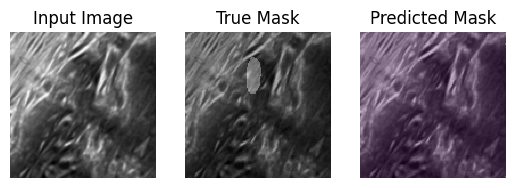

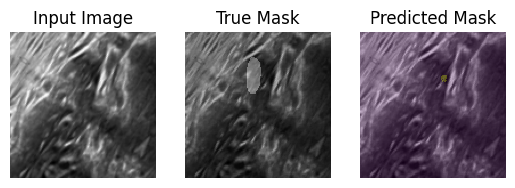

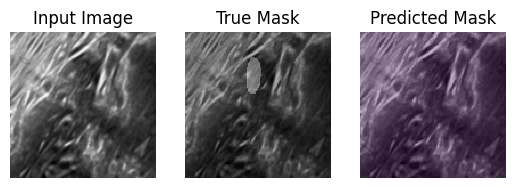

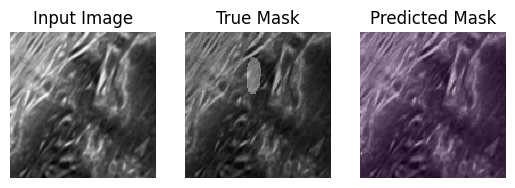

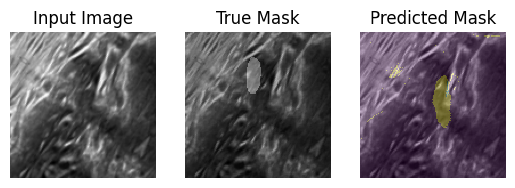

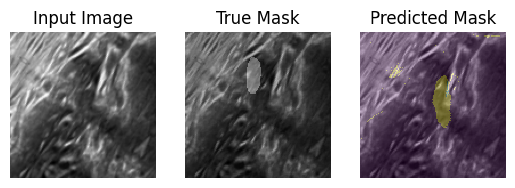

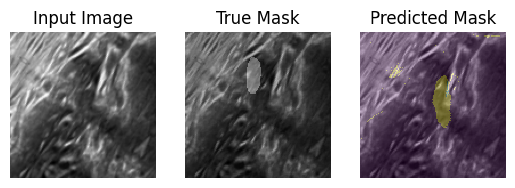

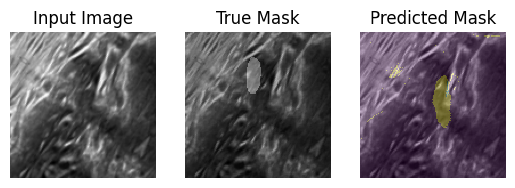

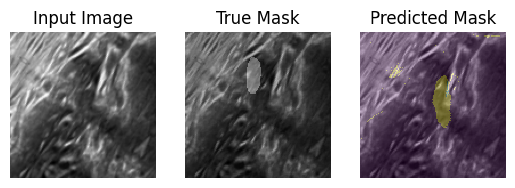

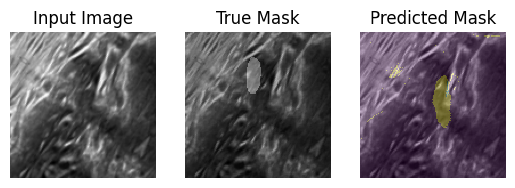

In [ ]:
#Correct results for model_unet_enc_pr and resunet. unet results are not finished + don't look at the images, they are wrong.

Epoch 1/20
30/30 [==============================] - 483s 16s/step - loss: 0.3049 - mean_io_u: 0.4962 - val_loss: 0.3518 - val_mean_io_u: 0.5258
Epoch 2/20
30/30 [==============================] - 432s 15s/step - loss: 0.2537 - mean_io_u: 0.4985 - val_loss: 0.2781 - val_mean_io_u: 0.4863
Epoch 3/20
30/30 [==============================] - 435s 14s/step - loss: 0.1971 - mean_io_u: 0.4977 - val_loss: 0.2233 - val_mean_io_u: 0.4854
Epoch 4/20
30/30 [==============================] - 435s 15s/step - loss: 0.1378 - mean_io_u: 0.4958 - val_loss: 0.1702 - val_mean_io_u: 0.4854
Epoch 5/20
30/30 [==============================] - 440s 15s/step - loss: 0.0909 - mean_io_u: 0.4949 - val_loss: 0.1204 - val_mean_io_u: 0.4854
Epoch 6/20
30/30 [==============================] - 448s 15s/step - loss: 0.0603 - mean_io_u: 0.4927 - val_loss: 0.0845 - val_mean_io_u: 0.4854
Epoch 7/20
30/30 [==============================] - 451s 15s/step - loss: 0.0416 - mean_io_u: 0.4905 - val_loss: 0.0632 - val_mean_io_u:

INFO:tensorflow:Assets written to: models/segm\assets


INFO:tensorflow:Assets written to: models/segm\assets


model saved:  models/segm


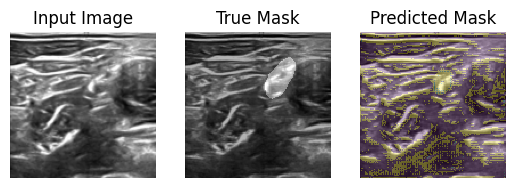

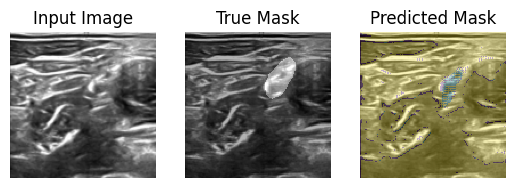

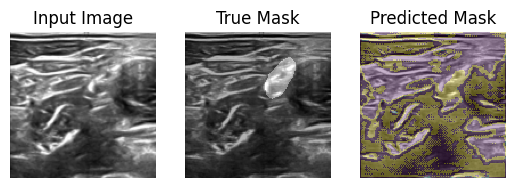

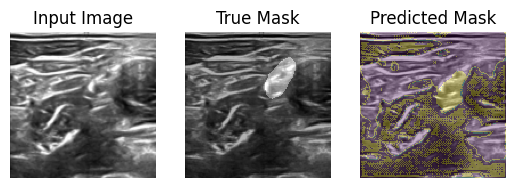

In [ ]:
#These results were for resunet, 1e-05, without regularization and augmentation

# res = fit_and_save_model_segm(
#     model_resunet, 
#     train_tf_dataset, 
#     valid_tf_dataset, 
#     epochs=EPOCHS, 
#     callbacks=[DisplayCallback()],
#     train_steps_per_epoch=TRAIN_STEPS_PER_EPOCH, 
#     val_steps_per_epoch=VAL_STEPS_PER_EPOCH, 
#     saveto="models/segm"
#     )